In [7]:
import numpy, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class ExternalRNN(object):
    """Class that implements a External Recurent Neural Network"""
    def __init__(self, hidden_layer_size=3, learning_rate=0.2, max_epochs=1000, delays=5, plot=False):
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.delays = delays
        self.plot = plot

    def fit(self, X, y):
        """Trains the network and returns the trained network"""
        self.input_layer_size = X.shape[1]
        self.output_layer_size = y.shape[1]
        remaining_epochs = self.max_epochs
        plot = self.plot

        # Initialize weights
        self.W1 = numpy.random.rand(1 + self.input_layer_size, self.hidden_layer_size)
        self.W2 = numpy.random.rand(1 + self.hidden_layer_size, self.output_layer_size)
        self.W3 = numpy.random.rand(self.output_layer_size * self.delays, self.hidden_layer_size)
        self.Ydelayed = numpy.zeros((1, self.output_layer_size * self.delays))

        epsilon = 0.001
        error = 1
        self.J = [] # error

        # Repeats until error is small enough or max epochs is reached
        while error > epsilon and remaining_epochs > 0:
            total_error = numpy.array([])

            # For each input instance
            for self.X, self.y in zip(X, y):
                self.X = numpy.array([self.X])
                self.y = numpy.array([self.y])
                error, gradients = self.single_step(self.X, self.y)
                total_error = numpy.append(total_error, error)
                dJdW1 = gradients[0]
                dJdW2 = gradients[1]
                dJdW3 = gradients[2]

                # Calculates new weights
                self.W1 = self.W1 - self.learning_rate * dJdW1
                self.W2 = self.W2 - self.learning_rate * dJdW2
                self.W3 = self.W3 - self.learning_rate * dJdW3

                # Shift Ydelayed values through time
                self.Ydelayed = numpy.roll(self.Ydelayed, 1, 1)
                self.Ydelayed[:,::self.delays] = self.Y

            # Saves error for plot
            if (plot == True):
                error = total_error.mean()
                self.J.append(error)
                #print ('Epoch: ' + str(remaining_epochs))
                #print ('Error: ' + str(error))

            remaining_epochs -= 1

        # After training, we plot error in order to see how it behaves
        if (plot == True):
            plt.plot(self.J[1:])
            plt.grid(1)
            plt.ylabel('Cost')
            plt.xlabel('Iterations')
            plt.show()

        return self

    def predict(self, X):
        """Predicts test values"""
        Y = list(map(lambda x: self.forward(numpy.array([x]))[0], X))
        #Y = list(map(lambda y: 1 if y > self.auc else 0, Y))
        return numpy.array(Y)

    def score(self, X, y_true):
        """Calculates accuracy"""
        y_pred = list(map(lambda x: self.forward(numpy.array([x]))[0], X))
        y_pred = numpy.array(y_pred)
        return mean_squared_error(y_true.flatten(), y_pred.flatten())

    def single_step(self, X, y):
        """Runs single step training method"""
        self.Y = self.forward(X)
        cost = self.cost(self.Y, y)
        gradients = self.backpropagate(X, y)

        return cost, gradients

    def forward(self, X):
        """Passes input values through network and return output values"""
        self.Zin = numpy.dot(X, self.W1[:-1,:])
        self.Zin += numpy.dot(numpy.ones((1, 1)), self.W1[-1:,:])
        self.Zin += numpy.dot(self.Ydelayed, self.W3)
        self.Z = self.sigmoid(self.Zin)
        self.Z = numpy.nan_to_num(self.Z)

        self.Yin = numpy.dot(self.Z, self.W2[:-1,])
        self.Yin += numpy.dot(numpy.ones((1, 1)), self.W2[-1:,:])
        Y = self.linear(self.Yin)
        Y = numpy.nan_to_num(Y)
        return Y

    def cost(self, Y, y):
        """Calculates network output error"""
        return mean_squared_error(Y, y)

    def backpropagate(self, X, y):
        """Backpropagates costs through the network"""
        delta3 = numpy.multiply(-(y-self.Y), self.linear_derivative(self.Yin))
        dJdW2 = numpy.dot(self.Z.T, delta3)
        dJdW2 = numpy.append(dJdW2, numpy.dot(numpy.ones((1, 1)), delta3), axis=0)

        delta2 = numpy.dot(delta3, self.W2[:-1,:].T)*self.sigmoid_derivative(self.Zin)
        dJdW1 = numpy.dot(X.T, delta2)
        dJdW1 = numpy.append(dJdW1, numpy.dot(numpy.ones((1, 1)), delta2), axis=0)

        dJdW3 = numpy.dot(numpy.repeat(self.Ydelayed, self.output_layer_size * self.delays, 0), 
                          numpy.repeat(delta2, self.output_layer_size * self.delays, 0))

        return dJdW1, dJdW2, dJdW3

    def sigmoid(self, z):
        """Apply sigmoid activation function"""
        return 1/(1+numpy.exp(-z))

    def sigmoid_derivative(self, z):
        """Derivative of sigmoid function"""
        return numpy.exp(-z)/((1+numpy.exp(-z))**2)

    def linear(self, z):
        """Apply linear activation function"""
        return z

    def linear_derivative(self, z):
        """Derivarive linear function"""
        return 1

Performing grid search: [                    ] 1%

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Performing grid search: [################    ] 82%

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide


Performing grid search: [####################] 99%
Erro quadrático médio no cj treino: 0.412087508608
Erro quadrático médio no cj teste: 0.0048512597495
Melhores hiperparâmetros: {'hidden_layer_size': 6, 'learning_rate': 0.5, 'delays': 5}


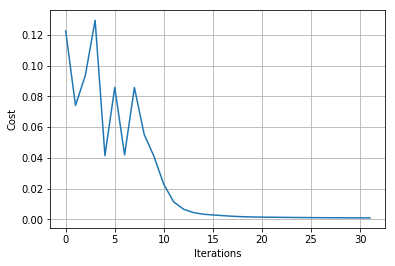

In [31]:
# -*- coding: utf-8 -*-

import sys, os
sys.path.insert(0, os.path.abspath('../..'))

import pandas, numpy, itertools ##, rnn, unittest
from sklearn import model_selection, preprocessing

class ExternalRNNTeste():
    """Test cases for World Population prediction problem."""
    grid_search = True

def run():
    """Tests the accuracy of a External RNN using k-folds validation method."""
    n_folds = 2
    
    # Read data from CSV files
    X_train, X_test, y_train, y_test = read_data()

    # Rescales data
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.fit_transform(X_test)
    y_train = min_max_scaler.fit_transform(y_train)
    y_test = min_max_scaler.fit_transform(y_test)    

    accuracies = list(map(lambda x: 0, hipergrid()))
    
    for idx, hiperparams in enumerate(hipergrid()):
        
        tss = model_selection.TimeSeriesSplit(n_splits=n_folds)
        
        for train_index, test_index in tss.split(X_train, y_train.ravel()):
            progress(((n_folds*idx)/(len(hipergrid())*n_folds)))
            X_train2, X_test2 = X_train[train_index], X_train[test_index]
            y_train2, y_test2 = y_train[train_index], y_train[test_index]
            classifier = ExternalRNN(**hiperparams).fit(X_train2, y_train2)
            accuracies[idx] += classifier.score(X_test2, y_test2)
                     
    # Finds which hiperparams give minimum error
    best_hiperparams = hipergrid()[accuracies.index(numpy.max(accuracies))]
    #accuracy = classifier.score(X_test, y_test)
    accuracy = classifier.score(X_test, y_test)
    
    print ("\nErro quadrático médio no cj treino: " + str(numpy.max(accuracies)/n_folds))
    print ("Erro quadrático médio no cj teste: " + str(accuracy))
    print ("Melhores hiperparâmetros: " + str(best_hiperparams))
    
    #plota o melhor classificador encontrado
    best_classifier = ExternalRNN(**best_hiperparams, plot=True).fit(X_train2, y_train2)

def read_data():
    # lê o dataset de treinamento
    train_X = pandas.read_csv('pop-entrada.csv', header=None)
    # lê o dataset de teste
    test_X = pandas.read_csv('pop-entrada.csv', header=None)
    # cria o dataset de rótulos
    train_Y = pandas.DataFrame(data=[])
    test_Y = pandas.DataFrame(data=[])
    # copia a última coluna de cada conjunto como rótulos
    train_Y = pandas.read_csv('pop-saida.csv', header=None)
    test_Y = pandas.read_csv('pop-saida.csv', header=None)    
    # remove do dataframe e retorna o resultado
    return train_X.as_matrix(), test_X.as_matrix(), train_Y.as_matrix(), test_Y.as_matrix()  

def hipergrid():
    """Hiperparameters for ExternalRNN"""
    hidden_layer_size = [{'hidden_layer_size':2},{'hidden_layer_size':3},{'hidden_layer_size':4},
                         {'hidden_layer_size':5},{'hidden_layer_size':6},{'hidden_layer_size':7}]
    learning_rate = [{'learning_rate':0.1},{'learning_rate':0.2},{'learning_rate':0.3},
                     {'learning_rate':0.4},{'learning_rate':0.5}]
    delays = [{'delays':2},{'delays':3},{'delays':4},
              {'delays':5},{'delays':6},{'delays':7}]
    grid = []
       
    for hiperparams in itertools.product(hidden_layer_size, learning_rate, delays):
        d = {}
        for hiperparam in hiperparams:
            d.update(hiperparam)
        grid.append(d)

    return grid

# Prints progress in STDOUT
def progress(percent):
    bar_length = 20
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPerforming grid search: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

if __name__ == '__main__':
    run()   